/tmp/ipython-input-1-691408556.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['smoking'].fillna(smoking_mode, inplace=True)
/tmp/ipython-input-1-691408556.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

Random Forest Accuracy: 0.9565846599131693
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96       370
         1.0       0.95      0.96      0.95       321

    accuracy                           0.96       691
   macro avg       0.96      0.96      0.96       691
weighted avg       0.96      0.96      0.96       691


SVM Accuracy: 0.9406657018813314
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94       370
         1.0       0.90      0.98      0.94       321

    accuracy                           0.94       691
   macro avg       0.94      0.94      0.94       691
weighted avg       0.94      0.94      0.94       691


KNN Accuracy: 0.9131693198263386
              precision    recall  f1-score   support

         0.0       0.97      0.86      0.91       370
         1.0       0.86      0.97      0.91       321

    accuracy                           0.91       691
   macro avg     

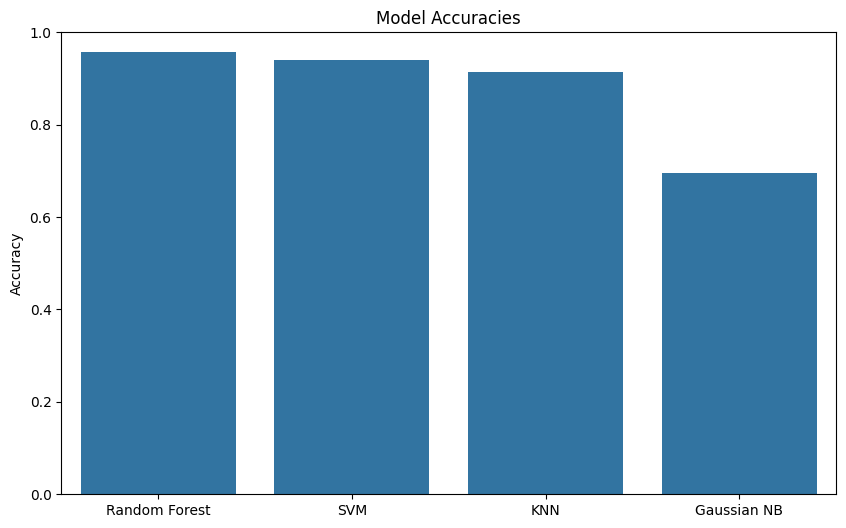

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns


dataset = pd.read_csv('/content/drive/MyDrive/practice/dataset_dementia.csv')


encoder = OneHotEncoder(drop='first', sparse_output=False)
dataset['gender'] = encoder.fit_transform(dataset[['gender']])
dataset['hypertension'] = encoder.fit_transform(dataset[['hypertension']])
dataset['hypercholesterolemia'] = encoder.fit_transform(dataset[['hypercholesterolemia']])

smoking_mode = dataset['smoking'].mode()[0]
dataset['smoking'].fillna(smoking_mode, inplace=True)
le = LabelEncoder()
dataset['smoking'] = le.fit_transform(dataset['smoking'])

dataset['EF'].fillna(dataset['EF'].mean(), inplace=True)
dataset['PS'].fillna(dataset['PS'].mean(), inplace=True)
dataset['Global'].fillna(dataset['Global'].mean(), inplace=True)
dataset['dementia'] = dataset['dementia'].apply(lambda x: 1 if pd.isnull(x) else x)


X = dataset.drop('dementia', axis=1)
y = dataset['dementia']

# Balance dataset with SMOTE
smt = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smt.fit_resample(X, y)


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ------------------- Random Forest -------------------
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}
rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, n_iter=20, cv=5, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

# ------------------- SVM -------------------
svm_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}
svm_model = RandomizedSearchCV(SVC(), svm_params, n_iter=15, cv=5, n_jobs=-1, random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)
print("\nSVM Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds))

# ------------------- KNN -------------------
knn_params = {
    'n_neighbors': list(range(3, 15)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
knn_model = RandomizedSearchCV(KNeighborsClassifier(), knn_params, n_iter=15, cv=5, n_jobs=-1, random_state=42)
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)
print("\nKNN Accuracy:", accuracy_score(y_test, knn_preds))
print(classification_report(y_test, knn_preds))

# ------------------- Gaussian Naive Bayes -------------------
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
gnb_preds = gnb_model.predict(X_test)
print("\nGaussian Naive Bayes Accuracy:", accuracy_score(y_test, gnb_preds))
print(classification_report(y_test, gnb_preds))

# ------------------- Visualization -------------------
accuracies = [
    accuracy_score(y_test, rf_preds),
    accuracy_score(y_test, svm_preds),
    accuracy_score(y_test, knn_preds),
    accuracy_score(y_test, gnb_preds)
]
models = ['Random Forest', 'SVM', 'KNN', 'Gaussian NB']

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title("Model Accuracies")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()
